# Load packages

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot #just for plotting

# Series to supervise function

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, n_f=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in-1, 0, -1):
		cols.append(df.loc[:,0:(n_f-1)].shift(i))
    #
	for i in range(n_in, 0, -1):    
		names += [('var%d(t-%d)' % (j+1, i-1)) for j in range(n_f)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % data.shape[1])]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_out)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# FIRST EXAMPLE: single sinusoidal (using keras timeseries generator

In [13]:
# Define functions

length = 720 # Number of hours (720 h = 30 days)

time = np.arange(0,length,1/2)

y = np.sin(2*np.pi*time/12.4206)   #sea level with M2 tidal period
x = np.sin(2*np.pi*(time+4)/12.4206) #Astronomical motion with M2 period with phase shift

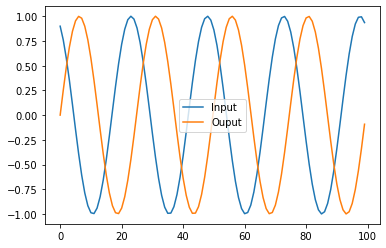

In [15]:
plt.plot(x[0:100])
plt.plot(y[0:100])
plt.legend(["Input", "Ouput"])
plt.show()

In [16]:
d = {'input1': x, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [17]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')

split_percent = 0.70
split = int(split_percent*len(values))

train = values[:split, :]
test = values[split:, :]

time_train = time[:split]
time_test = time[split:]

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
fit = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# frame as supervised learning
look_back = 15
n_features = 1
train_g = TimeseriesGenerator(train[:,0], train[:,1], length=look_back, batch_size=20)     
test_g = TimeseriesGenerator(test[:,0], test[:,1], length=look_back, batch_size=1)

# frame as supervised learning
#print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
#reframed.shape

In [18]:
train.max()

1.0

In [20]:
# design network
model = Sequential()
model.add(LSTM(6, input_shape=(look_back, 1))) #=(n_steps_in,n_features)
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_g[:,:n_features], train_g[:,n_features], epochs=20, validation_data=(test_g[:,:n_features],test_g[:,n_features]), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show


#Notes: Tried with with 1,2 neurons and 36 time steps neuron, it did not converge afer 100 epoch
#With 3 neurons and 36 time steps, it converged after 55 epochs

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

Test RMSE: 0.005
Test std: 0.707


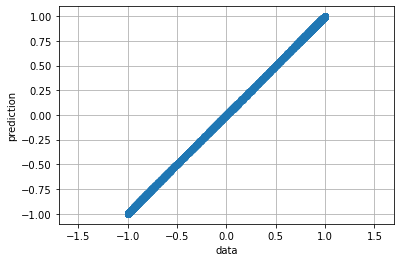

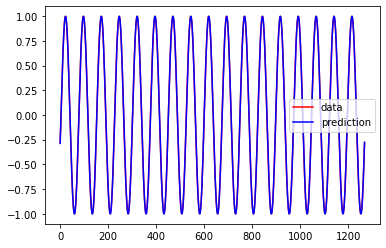

In [50]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y,'r',label="data")
pyplot.plot(inv_yhat,'b',label="prediction")
pyplot.legend()
pyplot.show()

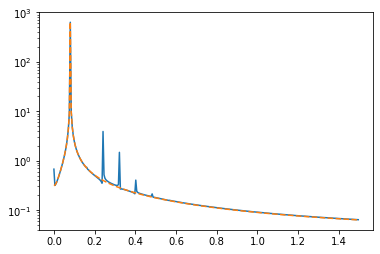

In [51]:
freq = np.fft.fftfreq(inv_y.size, d=time[1])[0:int(inv_y.size/4)]

fft_y = np.abs(np.fft.fft(inv_y))[0:int(inv_y.size/4)]
#fft_y = fft_y[0:int(inv_y.size/2)]
fft_yhat = np.abs(np.fft.fft(inv_yhat))[0:int(inv_yhat.size/4)]

pyplot.plot(freq,fft_yhat)
pyplot.plot(freq,fft_y,'--')
pyplot.yscale('log')


# FIRST EXAMPLE: single sinusoidal

In [21]:
# Define functions

length = 720 # Number of hours (720 h = 30 days)

time = np.arange(0,length,1/6)

y = np.sin(2*np.pi*time/12.4206)   #sea level with M2 tidal period
x = np.sin(2*np.pi*(time+4)/12.4206) #Astronomical motion with M2 period with phase shift

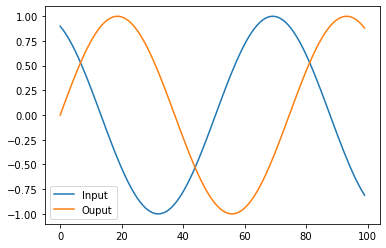

In [22]:
plt.plot(x[0:100])
plt.plot(y[0:100])
plt.legend(["Input", "Ouput"])
plt.show()

In [23]:
d = {'input1': x, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

# SECOND EXAMPLE: two sinusoidals M2+S2 

In [24]:
# Define functions

length = 1028 # Number of hours

time = np.arange(0,length,1/6)

y = np.sin(np.pi*time/12.4206) + 0.2*np.sin(np.pi*(time+2)/12)   #sea level with M2 tidal period
x1 = np.sin(np.pi*(time)/12.4206) #Astronomical motion with M2 period with phase shift
x2 = np.sin(np.pi*(time)/12)      #Astronomical motion with S2 period and a phase shift

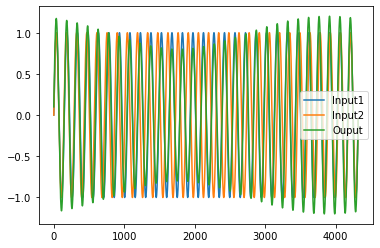

In [25]:
plt.plot(x1[0:720*6])
plt.plot(x2[0:720*6])
plt.plot(y[0:720*6])
plt.legend(["Input1","Input2","Ouput"])
plt.show()

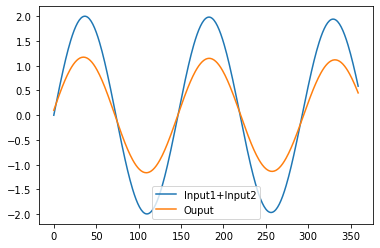

In [26]:
plt.plot(x1[0:360]+x2[0:360])
plt.plot(y[0:360])
plt.legend(["Input1+Input2","Ouput"])
plt.show()

In [27]:
d = {'input1': x1,'input2': x2, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [28]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_steps_in = 144  #specify the number of the previous time steps to use for the prediction = 1 in this case
n_steps_out = 1 #specify the number of time steps to predict = 1 in this case because we are predicting only 1 time step
n_features = 2 #number of features (variables) used to predict

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out, n_features)
#print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
#reframed.shape

In [29]:
# split into train and test sets
nsamples=reframed.shape[0] #=14107
values = reframed.values
n_train_periods = int(nsamples*0.7) #percentage for training
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]

# split into input and outputs 
n_obs = n_steps_in * n_features #(features=predictors) 

#for predicting sea level at time t using predictors at time<=t
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4217, 288) (4217,)
(4217, 144, 2) (4217,) (1808, 144, 2) (1808,)


In [30]:
# design network
model = Sequential()
#model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show

Train on 4217 samples, validate on 1808 samples
Epoch 1/30
 - 61s - loss: 0.1540 - val_loss: 0.0429
Epoch 2/30
 - 48s - loss: 0.0285 - val_loss: 0.0484
Epoch 3/30


KeyboardInterrupt: 

In [ ]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y,'r',label="data")
pyplot.plot(inv_yhat,'b',label="prediction")
pyplot.legend()
pyplot.show()

In [ ]:
freq = np.fft.fftfreq(inv_y.size, d=time[1])[0:int(inv_y.size/4)]

fft_y = np.abs(np.fft.fft(inv_y))[0:int(inv_y.size/4)]
#fft_y = fft_y[0:int(inv_y.size/2)]
fft_yhat = np.abs(np.fft.fft(inv_yhat))[0:int(inv_yhat.size/4)]

pyplot.plot(freq,fft_yhat)
pyplot.plot(freq,fft_y,'--')
pyplot.yscale('log')

# Different approach to two sinusoidals

In [168]:
# Define functions

length = 2*1440 # Number of hours

time = np.arange(0,length)

y = np.sin(2*np.pi*time/12.4206) + 0.2*np.sin(2*np.pi*(time+2)/12)   #sea level with M2 tidal period
x1 = np.sin(2*np.pi*(time+4)/12.4206) #Astronomical motion with M2 period with phase shift
x2 = np.sin(2*np.pi*(time+4)/12.4206)+np.sin(2*np.pi*(time)/12)      #Astronomical motion with S2 period and a phase shift

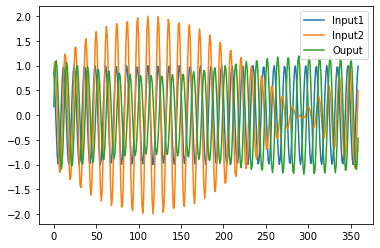

In [169]:
plt.plot(x1[0:360])
plt.plot(x2[0:360])
plt.plot(y[0:360])
plt.legend(["Input1","Input2","Ouput"])
plt.show()

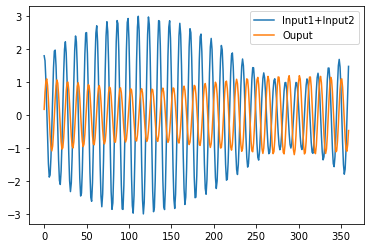

In [170]:
plt.plot(x1[0:360]+x2[0:360])
plt.plot(y[0:360])
plt.legend(["Input1+Input2","Ouput"])
plt.show()

In [171]:
d = {'input1': x1,'input2': x2, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [172]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_steps_in = 48  #specify the number of the previous time steps to use for the prediction = 1 in this case
n_steps_out = 1 #specify the number of time steps to predict = 1 in this case because we are predicting only 1 time step
n_features = 2 #number of features (variables) used to predict

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out, n_features)
#print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
#reframed.shape

In [173]:
# split into train and test sets
nsamples=reframed.shape[0] #=14107
values = reframed.values
n_train_periods = int(nsamples*0.7) #percentage for training
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]

# split into input and outputs 
n_obs = n_steps_in * n_features #(features=predictors) 

#for predicting sea level at time t using predictors at time<=t
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1983, 96) (1983,)
(1983, 48, 2) (1983,) (850, 48, 2) (850,)


Train on 1983 samples, validate on 850 samples
Epoch 1/50
 - 5s - loss: 0.1746 - val_loss: 0.1187
Epoch 2/50
 - 2s - loss: 0.0978 - val_loss: 0.0973
Epoch 3/50
 - 2s - loss: 0.0908 - val_loss: 0.0940
Epoch 4/50
 - 2s - loss: 0.0875 - val_loss: 0.0905
Epoch 5/50
 - 2s - loss: 0.0838 - val_loss: 0.0860
Epoch 6/50
 - 2s - loss: 0.0791 - val_loss: 0.0802
Epoch 7/50
 - 2s - loss: 0.0728 - val_loss: 0.0726
Epoch 8/50
 - 3s - loss: 0.0646 - val_loss: 0.0627
Epoch 9/50
 - 2s - loss: 0.0540 - val_loss: 0.0504
Epoch 10/50
 - 3s - loss: 0.0414 - val_loss: 0.0369
Epoch 11/50
 - 4s - loss: 0.0291 - val_loss: 0.0257
Epoch 12/50
 - 3s - loss: 0.0205 - val_loss: 0.0191
Epoch 13/50
 - 3s - loss: 0.0163 - val_loss: 0.0161
Epoch 14/50
 - 2s - loss: 0.0145 - val_loss: 0.0145
Epoch 15/50
 - 2s - loss: 0.0134 - val_loss: 0.0133
Epoch 16/50
 - 2s - loss: 0.0124 - val_loss: 0.0123
Epoch 17/50
 - 2s - loss: 0.0115 - val_loss: 0.0114
Epoch 18/50
 - 2s - loss: 0.0107 - val_loss: 0.0106
Epoch 19/50
 - 2s - loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

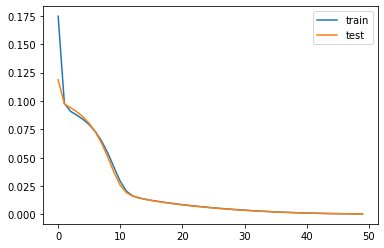

In [174]:
# design network
model = Sequential()
model.add(LSTM(6, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show

Test RMSE: 0.037
Test std: 0.722


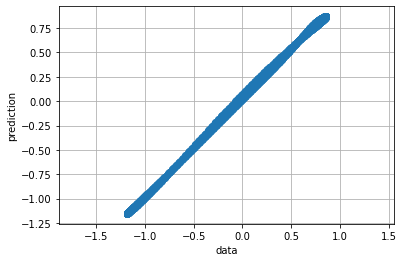

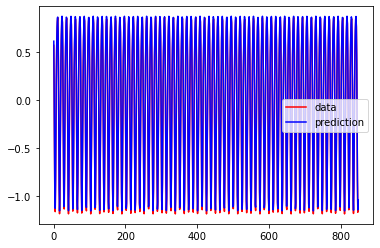

In [183]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y,'r',label="data")
pyplot.plot(inv_yhat,'b',label="prediction")
pyplot.legend()
pyplot.show()

# Two sinusoidals M2 + N2

In [186]:
# Define functions

length = 2000 # Number of hours
dt = 1/6
time = np.arange(0,length,dt)

y = np.sin(np.pi*time/12.4206) + 0.2*np.sin(np.pi*(time+1)/12.65834751)  #sea level with M2 tidal period
x1 = np.sin(np.pi*(time)/12.4206)*(1+0.05*(np.cos(np.pi*(time)/348))) #Astronomical motion with M2 period with phase shift


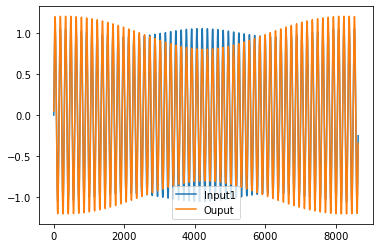

In [187]:
plt.plot(x1[0:720*12])
plt.plot(y[0:720*12])
plt.legend(["Input1","Ouput"])
plt.show()

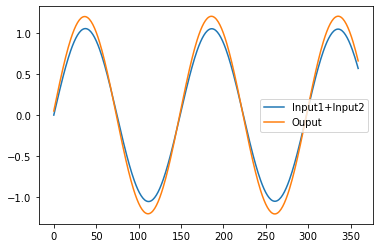

In [188]:
plt.plot(x1[0:360])
plt.plot(y[0:360])
plt.legend(["Input1+Input2","Ouput"])
plt.show()

In [189]:
d = {'input1': x1, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [192]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_steps_in = np.intc(48/dt)  # #hours/dt specify the number of the previous time steps to use for the prediction = 1 in this case
n_steps_out = 1 #specify the number of time steps to predict = 1 in this case because we are predicting only 1 time step
n_features = 1 #number of features (variables) used to predict

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out, n_features)
#print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
#reframed.shape

In [178]:
# split into train and test sets
nsamples=reframed.shape[0] #=14107
values = reframed.values
n_train_periods = int(nsamples*0.7) #percentage for training
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]

# split into input and outputs 
n_obs = n_steps_in * n_features #(features=predictors) 

#for predicting sea level at time t using predictors at time<=t
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8299, 144) (8299,)
(8299, 144, 1) (8299,) (3558, 144, 1) (3558,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(8, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show

Train on 8299 samples, validate on 3558 samples
Epoch 1/30
 - 85s - loss: 0.0765 - val_loss: 0.0019
Epoch 2/30
 - 91s - loss: 0.0014 - val_loss: 0.0024
Epoch 3/30
 - 108s - loss: 8.4942e-04 - val_loss: 0.0025
Epoch 4/30
 - 93s - loss: 7.2502e-04 - val_loss: 0.0025
Epoch 5/30
 - 92s - loss: 6.6153e-04 - val_loss: 0.0025
Epoch 6/30
 - 123s - loss: 6.1755e-04 - val_loss: 0.0025
Epoch 7/30
 - 118s - loss: 5.8389e-04 - val_loss: 0.0025
Epoch 8/30
 - 116s - loss: 5.5878e-04 - val_loss: 0.0025
Epoch 9/30
 - 100s - loss: 5.4193e-04 - val_loss: 0.0025
Epoch 10/30
 - 113s - loss: 5.3320e-04 - val_loss: 0.0025
Epoch 11/30
 - 139s - loss: 5.3194e-04 - val_loss: 0.0026
Epoch 12/30
 - 144s - loss: 5.3674e-04 - val_loss: 0.0026
Epoch 13/30
 - 117s - loss: 5.4563e-04 - val_loss: 0.0026
Epoch 14/30
 - 160s - loss: 5.5666e-04 - val_loss: 0.0026
Epoch 15/30
 - 128s - loss: 5.6833e-04 - val_loss: 0.0026
Epoch 16/30
 - 124s - loss: 5.7974e-04 - val_loss: 0.0026
Epoch 17/30
 - 115s - loss: 5.9034e-04 - val_

Test RMSE: 0.090
Test std: 0.712


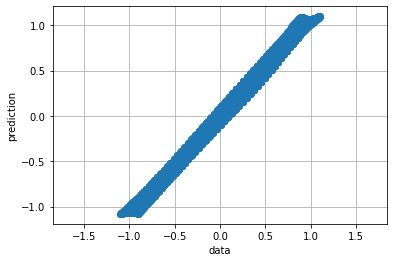

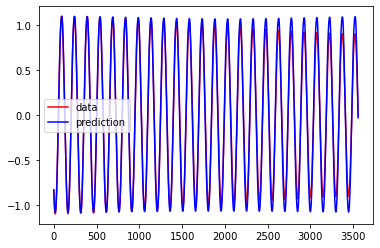

In [183]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y,'r',label="data")
pyplot.plot(inv_yhat,'b',label="prediction")
pyplot.legend()
pyplot.show()

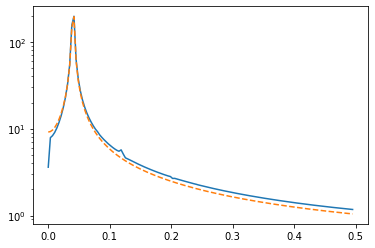

In [118]:
freq = np.fft.fftfreq(inv_y.size, d=time[1])[0:int(inv_y.size/4)]

fft_y = np.abs(np.fft.fft(inv_y))[0:int(inv_y.size/4)]
#fft_y = fft_y[0:int(inv_y.size/2)]
fft_yhat = np.abs(np.fft.fft(inv_yhat))[0:int(inv_yhat.size/4)]

pyplot.plot(freq,fft_yhat)
pyplot.plot(freq,fft_y,'--')
pyplot.yscale('log')

# THIRD EXAMPLE: single sinusoidal with dry periods

In [129]:
# Define functions

length = 1440 # Number of hours

time = np.arange(0,length)

y = np.sin(2*np.pi*time/12.4206)     #sea level with M2 tidal period
y[np.nonzero(y < 0)[0]]=0
x1 = np.sin(2*np.pi*(time+4)/12.4206) #Astronomical motion with M2 period with phase shift
x2 = x1*0+1 #Adding this constant does not seem to make much of a difference

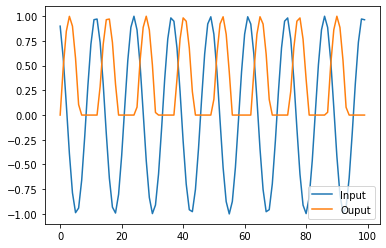

In [130]:
plt.plot(x1[0:100])
plt.plot(y[0:100])
plt.legend(["Input", "Ouput"])
plt.show()

In [131]:
d = {'input1': x1,'input2': x2, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [132]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_steps_in = 24  #specify the number of the previous time steps to use for the prediction = 1 in this case
n_steps_out = 1 #specify the number of time steps to predict = 1 in this case because we are predicting only 1 time step
n_features = 2 #number of features (variables) used to predict

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out, n_features)
print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
reframed.shape

    var1(t-23)  var2(t-23)  var1(t-22)  var2(t-22)  var1(t-21)  var2(t-21)  \
23    0.949642         0.0    0.787358         0.0    0.553093         0.0   
24    0.787358         0.0    0.553093         0.0    0.305529         0.0   
25    0.553093         0.0    0.305529         0.0    0.106679         0.0   
26    0.305529         0.0    0.106679         0.0    0.006352         0.0   
27    0.106679         0.0    0.006352         0.0    0.029681         0.0   

    var1(t-20)  var2(t-20)  var1(t-19)  var2(t-19)  ...  var2(t-4)  var1(t-3)  \
23    0.305529         0.0    0.106679         0.0  ...        0.0   0.293596   
24    0.106679         0.0    0.006352         0.0  ...        0.0   0.540124   
25    0.006352         0.0    0.029681         0.0  ...        0.0   0.776602   
26    0.029681         0.0    0.170821         0.0  ...        0.0   0.943793   
27    0.170821         0.0    0.394418         0.0  ...        0.0   0.999818   

    var2(t-3)  var1(t-2)  var2(t-2)  var1(t-

(1417, 49)

In [133]:
# split into train and test sets
nsamples=reframed.shape[0] #=14107
values = reframed.values
n_train_periods = int(nsamples*0.7) #percentage for training
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]

# split into input and outputs 
n_obs = n_steps_in * n_features #(features=predictors) 

#for predicting sea level at time t using predictors at time<=t
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(991, 48) (991,)
(991, 24, 2) (991,) (426, 24, 2) (426,)


Train on 991 samples, validate on 426 samples
Epoch 1/100
 - 4s - loss: 0.2239 - val_loss: 0.1938
Epoch 2/100
 - 1s - loss: 0.1765 - val_loss: 0.1550
Epoch 3/100
 - 1s - loss: 0.1459 - val_loss: 0.1370
Epoch 4/100
 - 1s - loss: 0.1366 - val_loss: 0.1358
Epoch 5/100
 - 1s - loss: 0.1351 - val_loss: 0.1332
Epoch 6/100
 - 1s - loss: 0.1327 - val_loss: 0.1310
Epoch 7/100
 - 1s - loss: 0.1304 - val_loss: 0.1285
Epoch 8/100
 - 1s - loss: 0.1277 - val_loss: 0.1256
Epoch 9/100
 - 2s - loss: 0.1245 - val_loss: 0.1221
Epoch 10/100
 - 1s - loss: 0.1207 - val_loss: 0.1179
Epoch 11/100
 - 1s - loss: 0.1162 - val_loss: 0.1128
Epoch 12/100
 - 1s - loss: 0.1106 - val_loss: 0.1067
Epoch 13/100
 - 1s - loss: 0.1039 - val_loss: 0.0991
Epoch 14/100
 - 1s - loss: 0.0956 - val_loss: 0.0900
Epoch 15/100
 - 1s - loss: 0.0856 - val_loss: 0.0789
Epoch 16/100
 - 1s - loss: 0.0736 - val_loss: 0.0659
Epoch 17/100
 - 1s - loss: 0.0599 - val_loss: 0.0515
Epoch 18/100
 - 1s - loss: 0.0454 - val_loss: 0.0374
Epoch 19/

<function matplotlib.pyplot.show(close=None, block=None)>

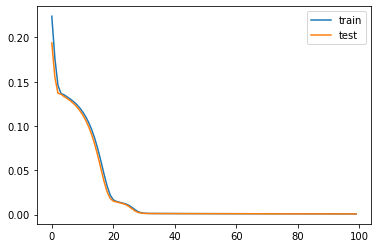

In [134]:
# design network
model = Sequential()
model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show


#Notes: Tried with with 1,2 neurons and 36 time steps neuron, it did not converge afer 100 epoch
#With 3 neurons and 36 time steps, it converged after 55 epochs

Test RMSE: 0.026
Test std: 0.385


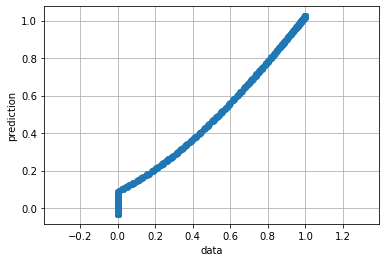

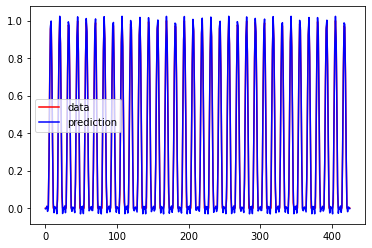

In [135]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y,'r',label="data")
pyplot.plot(inv_yhat,'b',label="prediction")
pyplot.legend()
pyplot.show()

In [76]:
test_X0.shape

(210, 24)

# Fourth Example: Higher harmonics

In [ ]:
# Define functions

length = 1440 # Number of hours

time = np.arange(0,length,0.5)

y = np.sin(2*np.pi*time/12.4206) + 0.2*np.sin(np.pi*(time+2)/12.4206/2)   #sea level with M2 tidal period
x1 = np.sin(2*np.pi*(time+3)/12.4206) #Astronomical motion with M2 period with phase shift
#x2 = np.sin(4*np.pi*(time)/12.4206)      #Astronomical motion with S2 period and a phase shift

In [ ]:
plt.plot(x1[0:60])
#plt.plot(x2[0:60])
plt.plot(y[0:60])
plt.legend(["Input1","Ouput"])
plt.show()

In [85]:
d = {'input1': x1, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [86]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_steps_in = 48  #specify the number of the previous time steps to use for the prediction = 1 in this case
n_steps_out = 1 #specify the number of time steps to predict = 1 in this case because we are predicting only 1 time step
n_features = 1 #number of features (variables) used to predict

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out, n_features)
#print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
#reframed.shape

In [87]:
# split into train and test sets
nsamples=reframed.shape[0] #=14107
values = reframed.values
n_train_periods = int(nsamples*0.7) #percentage for training
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]

# split into input and outputs 
n_obs = n_steps_in * n_features #(features=predictors) 

#for predicting sea level at time t using predictors at time<=t
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1983, 48) (1983,)
(1983, 48, 1) (1983,) (850, 48, 1) (850,)


Train on 1983 samples, validate on 850 samples
Epoch 1/50
 - 6s - loss: 0.7056 - val_loss: 0.5047
Epoch 2/50
 - 3s - loss: 0.3228 - val_loss: 0.1736
Epoch 3/50
 - 3s - loss: 0.1506 - val_loss: 0.1387
Epoch 4/50
 - 3s - loss: 0.1284 - val_loss: 0.1191
Epoch 5/50
 - 3s - loss: 0.1093 - val_loss: 0.1000
Epoch 6/50
 - 4s - loss: 0.0901 - val_loss: 0.0805
Epoch 7/50
 - 3s - loss: 0.0705 - val_loss: 0.0606
Epoch 8/50
 - 3s - loss: 0.0506 - val_loss: 0.0408
Epoch 9/50
 - 3s - loss: 0.0317 - val_loss: 0.0231
Epoch 10/50
 - 4s - loss: 0.0166 - val_loss: 0.0111
Epoch 11/50
 - 3s - loss: 0.0079 - val_loss: 0.0057
Epoch 12/50
 - 3s - loss: 0.0046 - val_loss: 0.0039
Epoch 13/50
 - 4s - loss: 0.0035 - val_loss: 0.0032
Epoch 14/50
 - 4s - loss: 0.0029 - val_loss: 0.0027
Epoch 15/50
 - 3s - loss: 0.0024 - val_loss: 0.0022
Epoch 16/50
 - 4s - loss: 0.0020 - val_loss: 0.0018
Epoch 17/50
 - 4s - loss: 0.0016 - val_loss: 0.0014
Epoch 18/50
 - 4s - loss: 0.0013 - val_loss: 0.0011
Epoch 19/50
 - 4s - loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

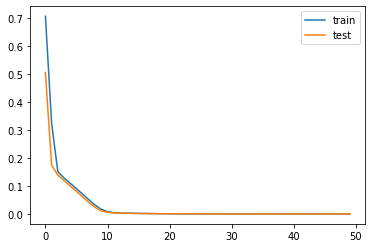

In [88]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=48, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show

Test RMSE: 0.021
Test std: 0.723


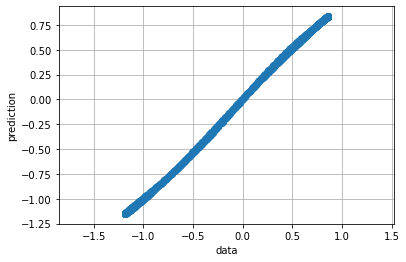

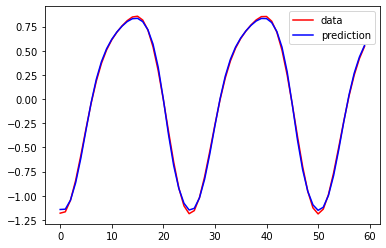

In [89]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y[0:60],'r',label="data")
pyplot.plot(inv_yhat[0:60],'b',label="prediction")
pyplot.legend()
pyplot.show()

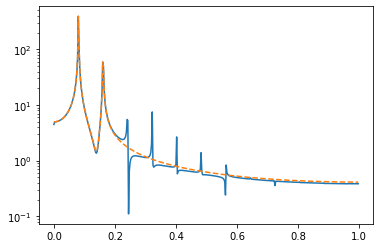

In [90]:
freq = np.fft.fftfreq(inv_y.size, d=time[1])[0:int(inv_y.size/2)]

fft_y = np.abs(np.fft.fft(inv_y))[0:int(inv_y.size/2)]
#fft_y = fft_y[0:int(inv_y.size/2)]
fft_yhat = np.abs(np.fft.fft(inv_yhat))[0:int(inv_yhat.size/2)]

pyplot.plot(freq,fft_yhat)
pyplot.plot(freq,fft_y,'--')
pyplot.yscale('log')

# Fourth Example: Higher harmonics

In [229]:
# Define functions

length = 2*1440 # Number of hours

time = np.arange(0,length)

y = np.sin(2*np.pi*time/12.4206) + 0.2*np.sin(4*np.pi*(time+2)/12.4206)   #sea level with M2 tidal period
x1 = np.sin(2*np.pi*(time+3)/12.4206) #Astronomical motion with M2 period with phase shift
#x2 = np.sin(4*np.pi*(time)/12.4206)      #Astronomical motion with S2 period and a phase shift

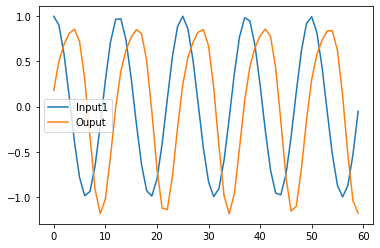

In [230]:
plt.plot(x1[0:60])
#plt.plot(x2[0:60])
plt.plot(y[0:60])
plt.legend(["Input1","Ouput"])
plt.show()

In [231]:
d = {'input1': x1, 'ouput':y}
dataset = pd.DataFrame(data=d)
values = dataset.values

In [232]:
# Prepare data for model
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_steps_in = 48  #specify the number of the previous time steps to use for the prediction = 1 in this case
n_steps_out = 1 #specify the number of time steps to predict = 1 in this case because we are predicting only 1 time step
n_features = 1 #number of features (variables) used to predict

# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps_in, n_steps_out, n_features)
#print(reframed.head()) #(nsamples, 4*(n_steps_in+n_steps_out))
#reframed.shape

In [233]:
# split into train and test sets
nsamples=reframed.shape[0] #=14107
values = reframed.values
n_train_periods = int(nsamples*0.7) #percentage for training
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]

# split into input and outputs 
n_obs = n_steps_in * n_features #(features=predictors) 

#for predicting sea level at time t using predictors at time<=t
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1983, 48) (1983,)
(1983, 48, 1) (1983,) (850, 48, 1) (850,)


Train on 1983 samples, validate on 850 samples
Epoch 1/50
 - 13s - loss: 0.1643 - val_loss: 0.1158
Epoch 2/50
 - 5s - loss: 0.0919 - val_loss: 0.0764
Epoch 3/50
 - 4s - loss: 0.0713 - val_loss: 0.0665
Epoch 4/50
 - 8s - loss: 0.0621 - val_loss: 0.0574
Epoch 5/50
 - 11s - loss: 0.0526 - val_loss: 0.0473
Epoch 6/50
 - 5s - loss: 0.0419 - val_loss: 0.0361
Epoch 7/50
 - 4s - loss: 0.0304 - val_loss: 0.0245
Epoch 8/50
 - 4s - loss: 0.0193 - val_loss: 0.0142
Epoch 9/50
 - 4s - loss: 0.0105 - val_loss: 0.0073
Epoch 10/50
 - 4s - loss: 0.0057 - val_loss: 0.0045
Epoch 11/50
 - 5s - loss: 0.0040 - val_loss: 0.0037
Epoch 12/50
 - 4s - loss: 0.0035 - val_loss: 0.0034
Epoch 13/50
 - 4s - loss: 0.0032 - val_loss: 0.0030
Epoch 14/50
 - 4s - loss: 0.0029 - val_loss: 0.0028
Epoch 15/50
 - 5s - loss: 0.0026 - val_loss: 0.0025
Epoch 16/50
 - 5s - loss: 0.0023 - val_loss: 0.0022
Epoch 17/50
 - 5s - loss: 0.0021 - val_loss: 0.0020
Epoch 18/50
 - 4s - loss: 0.0019 - val_loss: 0.0018
Epoch 19/50
 - 4s - loss

<function matplotlib.pyplot.show(close=None, block=None)>

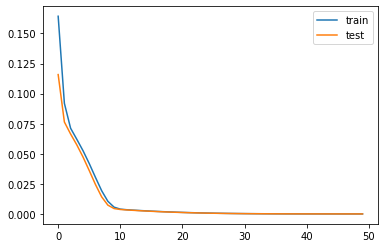

In [234]:
# design network
model = Sequential()
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(4, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) #=(n_steps_in,n_features)
#model.add(LSTM(2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam') #mean absolute error "mse" "mae"
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show

Test RMSE: 0.011
Test std: 0.722


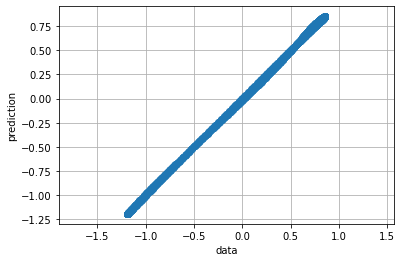

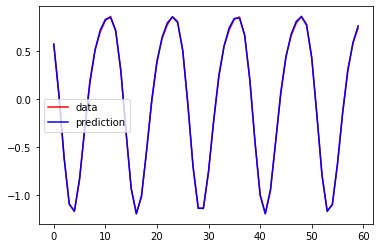

In [235]:
# %% Make a prediction
yhat = model.predict(test_X)
test_X0 = test_X.reshape((test_X.shape[0], n_steps_in*n_features))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = concatenate((test_X0,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat[:,-(n_features+1):])
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y0 = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = concatenate((test_X0,test_y0), axis=1)
inv_y = scaler.inverse_transform(inv_y[:,-(n_features+1):])
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test std: %.3f' % inv_y.std())


pyplot.plot(inv_y, inv_yhat,'o')
pyplot.xlabel("data")
pyplot.ylabel("prediction")
pyplot.grid()
pyplot.axis([500,900,500,900])
pyplot.axis("equal")
pyplot.show()


pyplot.plot(inv_y[0:60],'r',label="data")
pyplot.plot(inv_yhat[0:60],'b',label="prediction")
pyplot.legend()
pyplot.show()